In [72]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from tabulate import tabulate
from sklearn.metrics import mean_squared_error
df = pd.read_csv("Merged_WB_PWT_DEMO.csv", encoding="utf-8-sig")
df.columns = [c.lower().strip().replace(" ", "_") for c in df.columns]
df = df.replace('..', np.nan)
wb_wide = df.pivot_table(
    index=["country", "year"],
    columns="series_code",
    values="wb_value",
    aggfunc="first"
).reset_index()
wb_rename = {
    "NY.GDP.PCAP.KD": "gdp_pc",             
    "NE.TRD.GNFS.ZS": "trade_openness",     
    "FP.CPI.TOTL.ZG": "inflation",         
    "BX.KLT.DINV.WD.GD.ZS": "FDI",         
    "NE.GDI.TOTL.ZS": "investment_ratio"    
}
wb_wide = wb_wide.rename(columns={k: v for k, v in wb_rename.items() if k in wb_wide.columns})
if "gdp_pc" in wb_wide.columns:
    wb_wide["gdp_pc"] = pd.to_numeric(wb_wide["gdp_pc"], errors="coerce")
    wb_wide = wb_wide.sort_values(["country", "year"])
    wb_wide["gdp_pc_growth"] = (
        wb_wide.groupby("country")["gdp_pc"].pct_change() * 100
    )
base_cols = [
    "country", "country_code", "series_name", "series_code",
    "year", "wb_value", "countrycode", "currency_unit",
    "demographic_indicator", "unnamed:_3", "unnamed:_4",
    "unnamed:_5", "unnamed:_6"
]
base_cols = [c for c in base_cols if c in df.columns]
pwt_cols = [c for c in df.columns if c not in base_cols]
pwt_panel = df.groupby(["country", "year"], as_index=False)[pwt_cols].first()
if "pop" in pwt_panel.columns:
    pwt_panel = pwt_panel.sort_values(["country", "year"])
    pwt_panel["pop_growth"] = (
        pwt_panel.groupby("country")["pop"].pct_change() * 100
    )
if "hc" in pwt_panel.columns:
    pwt_panel = pwt_panel.rename(columns={"hc": "education"})
wgi = pd.read_excel("wgidataset.xlsx")
wgi.columns = [c.lower().strip() for c in wgi.columns]
wgi = wgi.rename(columns={"countryname": "country"})
wgi["estimate"] = pd.to_numeric(wgi["estimate"], errors="coerce")
wgi_pivot = wgi.pivot_table(
    index=["country", "year"],
    columns="indicator",
    values="estimate",
    aggfunc="mean"
).reset_index()
print("WGI columns:", wgi_pivot.columns)
panel = wb_wide.merge(pwt_panel, on=["country", "year"], how="left") \
               .merge(wgi_pivot, on=["country", "year"], how="left")
print(panel.columns.tolist())
print(panel.head())

/var/folders/92/394r745n3cxg7hwft9b6jmt40000gn/T/ipykernel_10763/3393062247.py:19: DtypeWarning:

Columns (56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.



WGI columns: Index(['country', 'year', 'cc', 'ge', 'pv', 'rl', 'rq', 'va'], dtype='object', name='indicator')
['country', 'year', 'EG.ELC.ACCS.ZS', 'GC.DOD.TOTL.GD.ZS', 'GC.NLD.TOTL.GD.ZS', 'MS.MIL.XPND.GD.ZS', 'trade_openness', 'NY.ADJ.NNTY.KD.ZG', 'NY.GDP.MKTP.KD.ZG', 'gdp_pc', 'gdp_pc_growth', 'rgdpe', 'rgdpo', 'pop', 'emp', 'avh', 'education', 'ccon', 'cda', 'cgdpe', 'cgdpo', 'cn', 'ck', 'ctfp', 'cwtfp', 'rgdpna', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'i_cig', 'i_xm', 'i_xr', 'i_outlier', 'i_irr', 'cor_exp', 'csh_c', 'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m', 'pl_n', 'pl_k', 'pop_growth', 'cc', 'ge', 'pv', 'rl', 'rq', 'va']
   country  year EG.ELC.ACCS.ZS GC.DOD.TOTL.GD.ZS GC.NLD.TOTL.GD.ZS  \
0  Albania  1980            NaN               NaN               NaN   
1  Albania  1981            NaN               NaN               NaN   
2  Albania  1982            Na

In [49]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
target = "gdp_pc_growth"
candidate_features = [
    "va", "pv", "ge", "rq", "rl", "cc",
    "pop_growth", "education",
    "trade_openness", "inflation", "FDI", "investment_ratio",
    "rgdpe", "rgdpo", "pop"
]
features = [f for f in candidate_features if f in panel.columns]
#print("Using features:", features)
model_df = panel.dropna(subset=[target]).copy()
model_df = model_df.replace('..', np.nan)
for col in features + [target]:
    model_df[col] = pd.to_numeric(model_df[col], errors='coerce')
model_df = model_df.dropna(subset=features + [target])
X = model_df[features]
y = model_df[target]
print(X.dtypes)

print("Any '..' left in X? ->", (X == '..').any().any())
y_binned = pd.qcut(y, q=3, labels=['Low', 'Medium', 'High'])
y_numeric = y_binned.map({'Low': 0, 'Medium': 1, 'High': 2})
#turns our y variable into an integer value for low, medium, and high
#goal is to have a classification model

corr_matrix = X.corr().abs()

# Upper triangle to avoid duplicate pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation > 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print("Highly correlated features to consider dropping:", to_drop)

# Drop them from X
X_reduced = X.drop(columns=to_drop)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y_numeric, test_size=0.25, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=.5,random_state=0)
print(X_reduced.columns)

va                float64
pv                float64
ge                float64
rq                float64
rl                float64
cc                float64
pop_growth        float64
education         float64
trade_openness    float64
rgdpe             float64
rgdpo             float64
pop               float64
dtype: object
Any '..' left in X? -> False
Highly correlated features to consider dropping: ['rq', 'rl', 'cc', 'rgdpo']
Index(['va', 'pv', 'ge', 'pop_growth', 'education', 'trade_openness', 'rgdpe',
       'pop'],
      dtype='object')


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
param_grid = {
    'n_estimators': [300,600,900],
    'max_depth': [6,10,15],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
rf_best  = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score: 0.5306850714658209


In [20]:


#rf = RandomForestClassifier(max_depth = 12, min_samples_leaf =1, min_samples_split = 2, n_estimators = 200, random_state = 42)
#rf.fit(X_train, y_train)
y_pred_valid = grid.predict(X_valid)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid))
print("\nConfusion Matrix:\n", confusion_matrix(y_valid, y_pred_valid))

# Optional: evaluate on test set
y_pred_test = grid.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print(X_reduced.columns)


Validation Accuracy: 0.590027700831025

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.54      0.58       134
           1       0.46      0.56      0.51       108
           2       0.71      0.66      0.68       119

    accuracy                           0.59       361
   macro avg       0.60      0.59      0.59       361
weighted avg       0.60      0.59      0.59       361


Confusion Matrix:
 [[73 47 14]
 [28 61 19]
 [16 24 79]]
Test Accuracy: 0.5359116022099447
Index(['va', 'pv', 'ge', 'pop_growth', 'education', 'trade_openness', 'rgdpe',
       'pop'],
      dtype='object')


In [21]:
model_df["growth_group"] = y_binned
country_summary = model_df[["country", "year", "growth_group"]]
country_summary

,country,year,growth_group
16,Albania,1996,High
18,Albania,1998,High
20,Albania,2000,High
22,Albania,2002,High
23,Albania,2003,High
...,...,...,...
8877,Zimbabwe,2019,Low
8878,Zimbabwe,2020,Low
8879,Zimbabwe,2021,High
8880,Zimbabwe,2022,High


In [22]:
X_full = X_reduced
pred_full = grid.predict(X_full)

model_df["predicted_group"] = pred_full
model_df

,country,year,EG.ELC.ACCS.ZS,GC.DOD.TOTL.GD.ZS,GC.NLD.TOTL.GD.ZS,MS.MIL.XPND.GD.ZS,trade_openness,NY.ADJ.NNTY.KD.ZG,NY.GDP.MKTP.KD.ZG,gdp_pc,...,pl_k,pop_growth,cc,ge,pv,rl,rq,va,growth_group,predicted_group
16,Albania,1996,100,37.0772780150153,-10.4379079348905,1.37902962734156,44.411782,35.2222652958929,7.33632894771891,1683.769655,...,0.204480,-0.395542,-0.893903,-0.688588,-0.336625,-0.684482,-0.474402,-0.648298,High,2
18,Albania,1998,100,54.4034191327832,-9.94852432937359,1.23824256064749,47.130627,7.21105389445972,8.3100252038309,1630.438741,...,0.194327,-0.604615,-0.992025,-0.732603,-0.544004,-0.929672,-0.441556,-0.387373,High,2
20,Albania,2000,99.4,NaN,NaN,1.24636024189216,61.609261,10.810913131353,7.46285871776054,1991.914359,...,0.223596,-0.703978,-0.855564,-0.917780,-0.539990,-1.020668,-0.415910,-0.285139,High,2
22,Albania,2002,99.4,NaN,-6.56017188461797,1.32003449433204,65.991465,3.10689333836432,4.62839587394552,2297.108535,...,0.252385,-0.440002,-0.845341,-0.624333,-0.297719,-0.762321,-0.311401,-0.008150,High,2
23,Albania,2003,99.4,NaN,-2.80921637775244,1.33684292419802,64.823215,5.53137085587394,5.33326426009945,2428.689347,...,0.296303,-0.510642,-0.853787,-0.563987,-0.309780,-0.716323,-0.490217,0.070308,High,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8877,Zimbabwe,2019,46.7,NaN,NaN,0.729567173018744,55.795984,-21.5878966072828,-6.33244975108572,1356.838211,...,1.346716,1.575821,-1.290334,-1.310435,-0.943303,-1.311041,-1.486515,-1.164831,Low,0
8878,Zimbabwe,2020,52.7,NaN,NaN,0.997931278066502,47.313382,-14.8935238086095,-7.81693284075131,1230.191557,...,1.353769,1.673197,-1.308788,-1.342368,-1.052743,-1.337362,-1.434415,-1.114599,Low,0
8879,Zimbabwe,2021,49,NaN,NaN,1.48153178684419,50.847123,38.9784503674931,8.46803916934418,1311.531000,...,1.064607,1.740993,-1.277147,-1.290561,-0.954443,-1.282122,-1.386109,-1.141045,High,2
8880,Zimbabwe,2022,50.1,NaN,NaN,0.780493773523229,64.763607,NaN,6.1391761744749,1368.498418,...,1.006796,1.720848,-1.259969,-1.251224,-0.894974,-1.237028,-1.425967,-1.109503,High,0


In [23]:
predicted_country_rank = (
    model_df.groupby("country")["predicted_group"]
    .mean()
    .sort_values()
)


In [24]:
importances = pd.Series(grid.best_estimator_.feature_importances_, index=X_reduced.columns)
print(importances.sort_values(ascending=False))

pop_growth        0.154428
pop               0.136993
ge                0.128742
education         0.122273
va                0.121713
rgdpe             0.113915
trade_openness    0.113796
pv                0.108140
dtype: float64


In [25]:
model_df.groupby("growth_group")[features].mean()

,va,pv,ge,rq,rl,cc,pop_growth,education,trade_openness,rgdpe,rgdpo,pop
growth_group,,,,,,,,,,,,
Low,0.033850,-0.070644,0.126568,0.176914,0.094425,0.114453,1.779524,2.567863,82.947078,6.744021e+05,6.805325e+05,27.608334
Medium,0.257579,0.043049,0.306976,0.357154,0.249874,0.249861,1.397238,2.606199,80.729311,1.001477e+06,1.004839e+06,40.431574
High,-0.028902,-0.082373,0.015223,0.072123,-0.073953,-0.105109,1.089640,2.553588,89.245853,9.081935e+05,9.156294e+05,87.758674


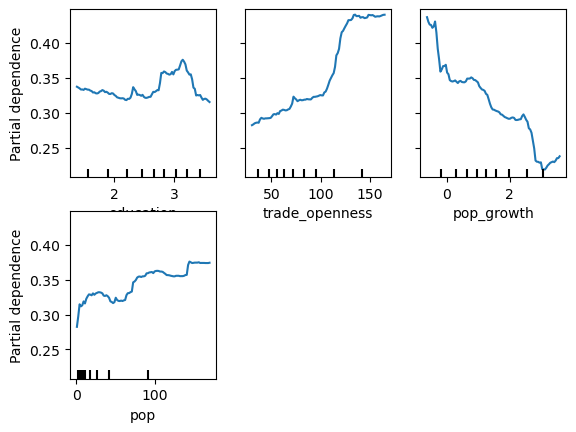

In [26]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    grid.best_estimator_,
    X_reduced,
    ["education", "trade_openness", "pop_growth", "pop"],
    target=2   # 2 = High-growth class
)
plt.show()

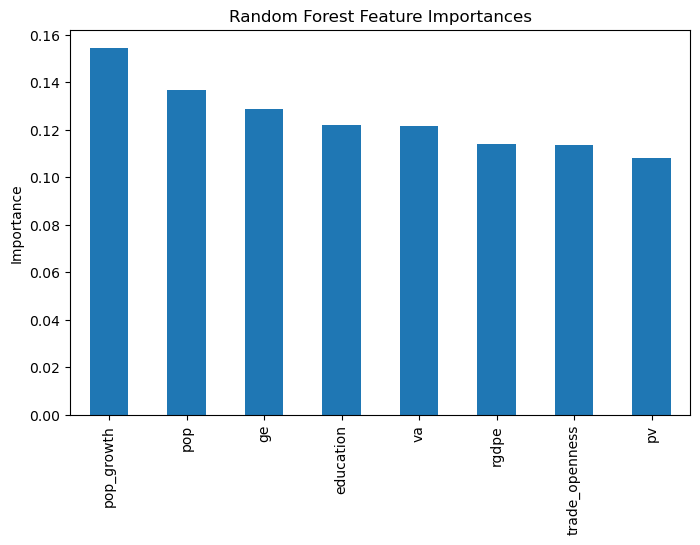

In [27]:
importances = grid.best_estimator_.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)

feat_importances.plot(kind='bar', figsize=(8,5))
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.show()


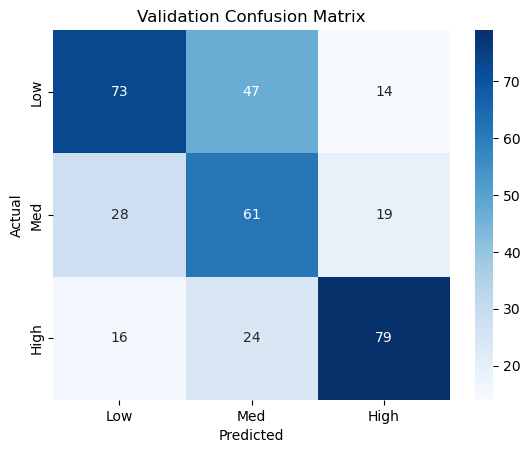

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_pred_valid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Med','High'], yticklabels=['Low','Med','High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()


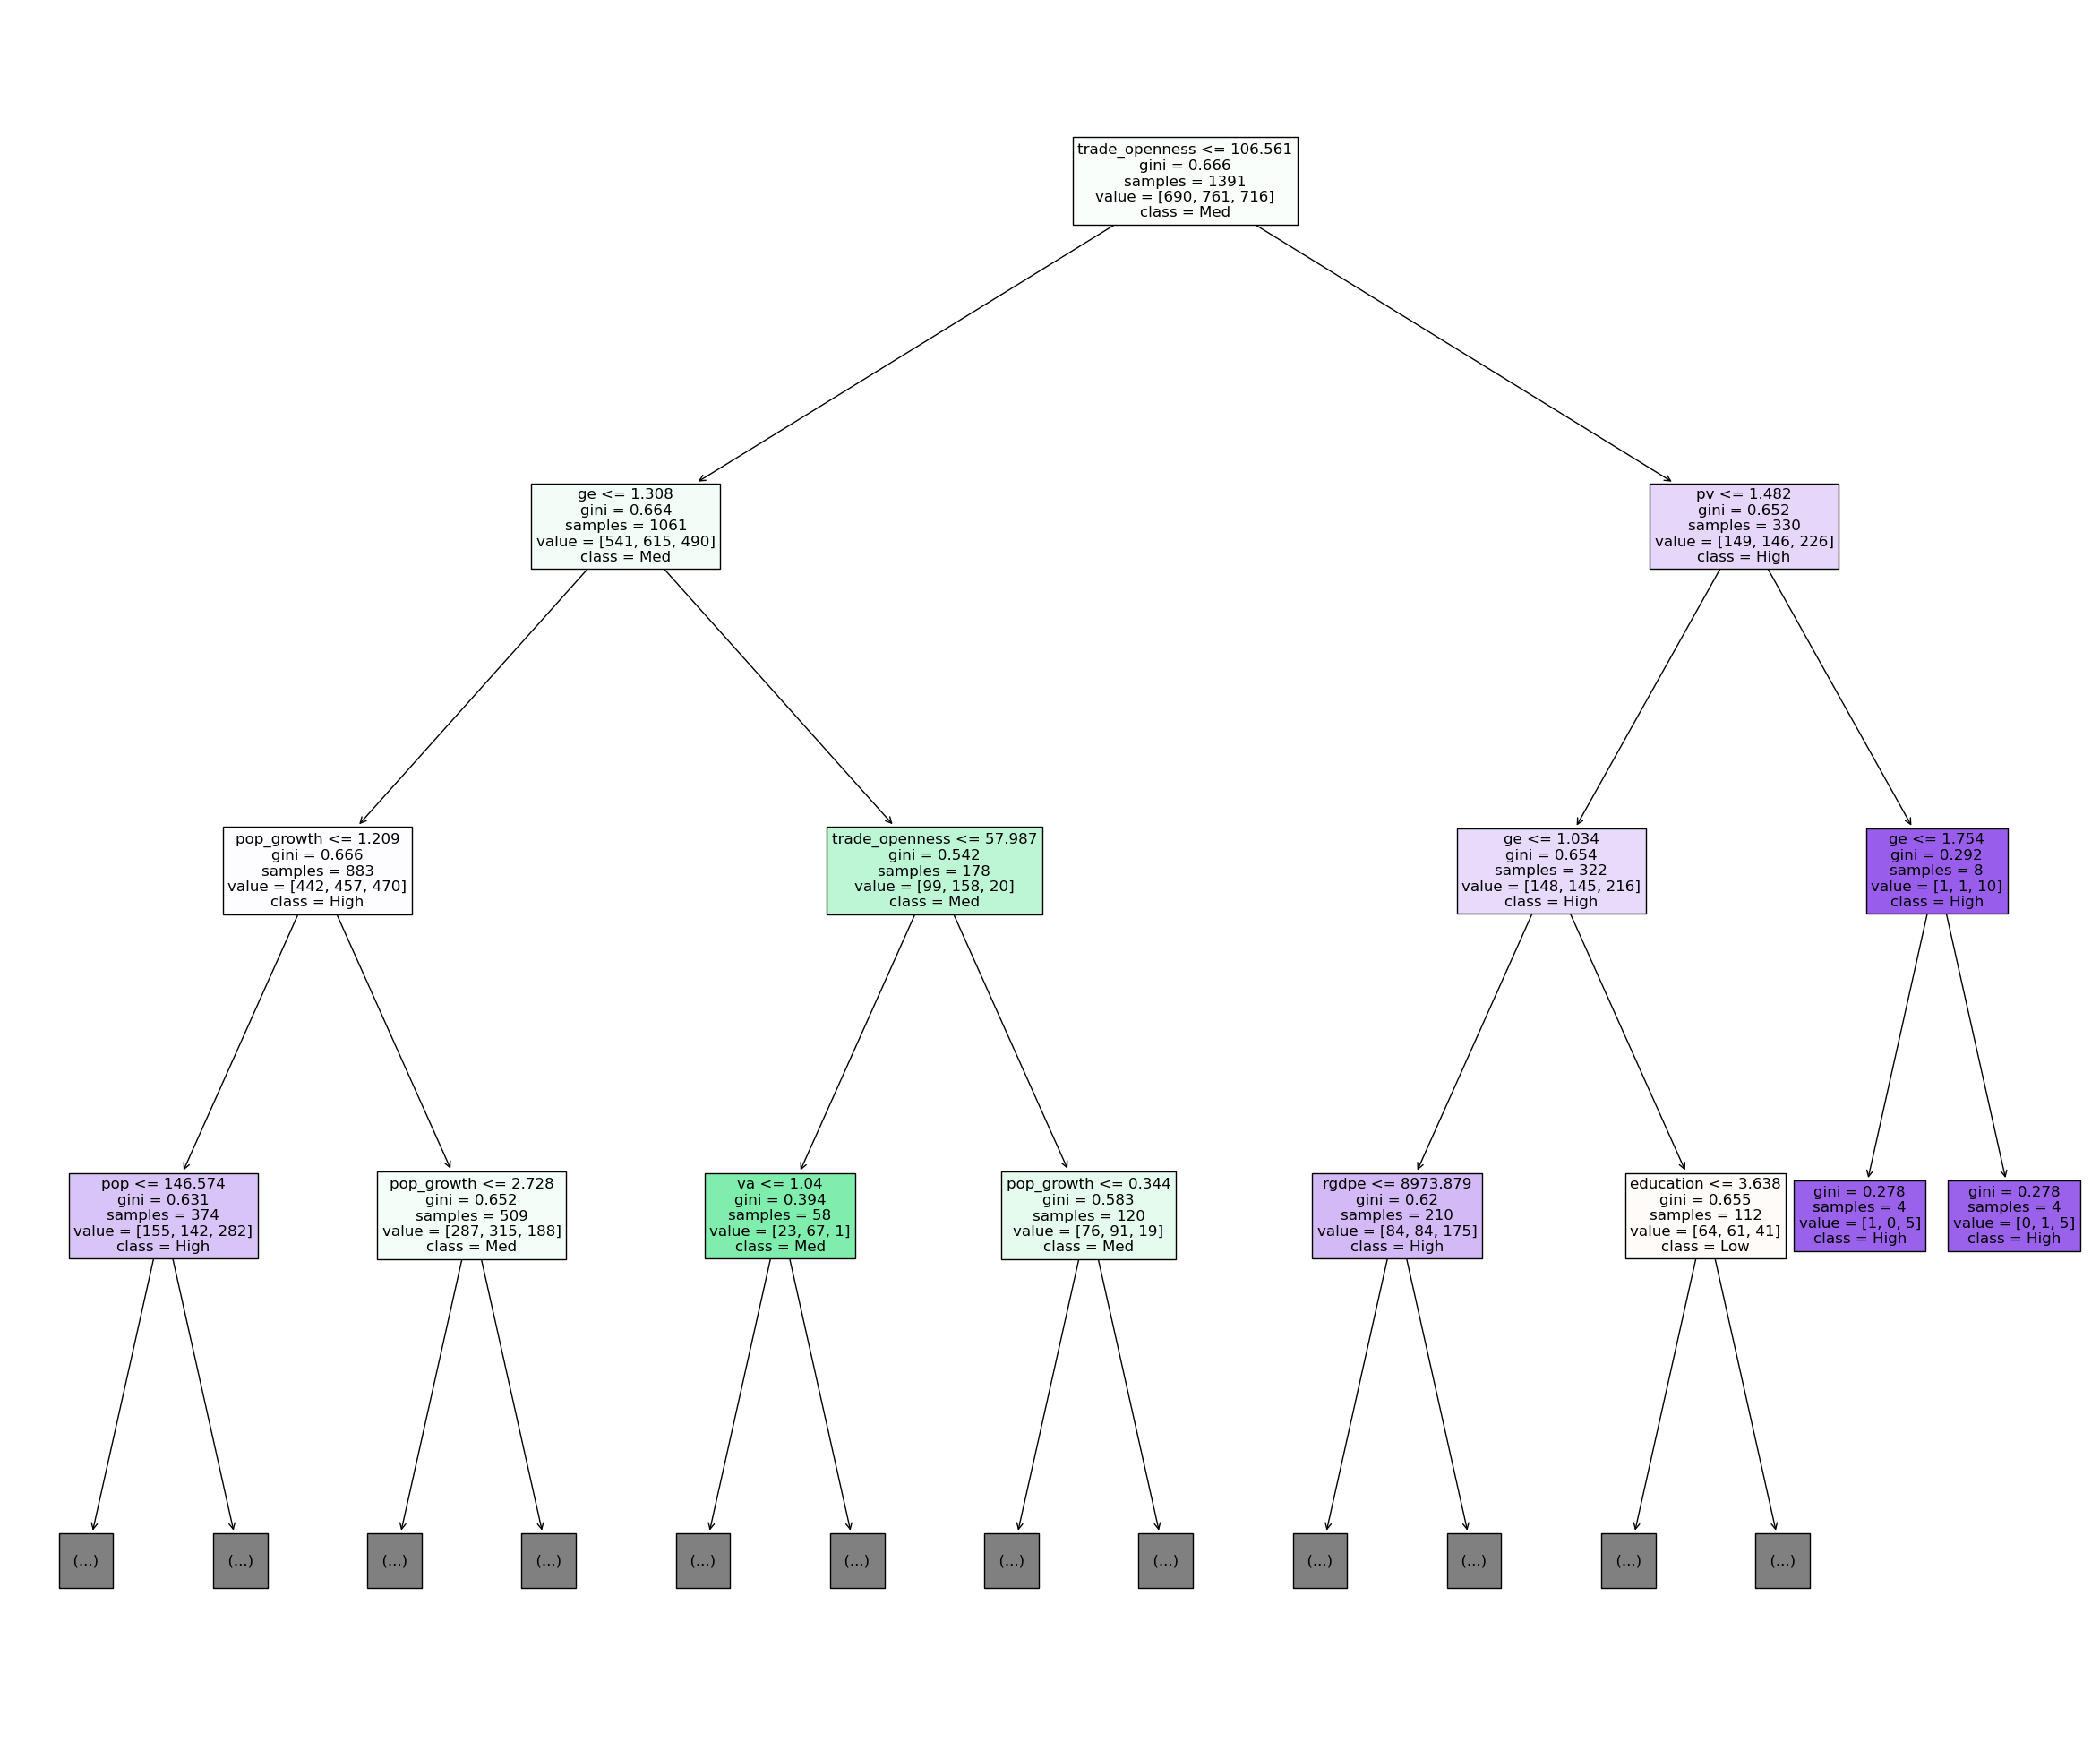

In [29]:
from sklearn.tree import plot_tree


plt.figure(figsize=(30,25))
plot_tree(
    grid.best_estimator_.estimators_[0],
    feature_names=X_train.columns.tolist(),  # convert Index to list
    class_names=['Low','Med','High'],
    filled=True,
    max_depth=3,fontsize=12
)
plt.show()

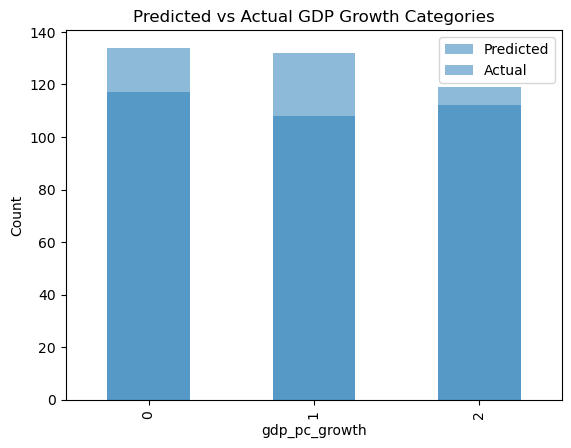

In [30]:
preds = rf_best.predict(X_valid)
pd.Series(preds).value_counts().sort_index().plot(kind='bar', alpha=0.5, label='Predicted')
pd.Series(y_valid).value_counts().sort_index().plot(kind='bar', alpha=0.5, label='Actual')
plt.legend()
plt.ylabel("Count")
plt.title("Predicted vs Actual GDP Growth Categories")
plt.show()

In [32]:

import pandas as pd
import matplotlib.pyplot as plt
country_map = {
    'United States': 'United States of America',
    'Russia': 'Russian Federation',  # probably already matches
    'Viet Nam': 'Vietnam',
    'Brunei Darussalam': 'Brunei',
    'Syrian Arab Republic': 'Syria',
    'Czech Republic': 'Czechia',  # if you have Czechia
    'Iran': 'Iran, Islamic Republic of',
    'Democratic Republic of the Congo': 'Congo, Democratic Republic of the',
    'Republic of the Congo': 'Congo',
    'Eswatini': 'Swaziland',
    'North Macedonia': 'Macedonia',
    'South Korea': 'Korea, Republic of',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'Laos': 'Lao People\'s Democratic Republic',
    'Moldova': 'Moldova, Republic of',
    'Tanzania': 'Tanzania, United Republic of',
    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
    'Palestine': 'Palestine, State of',
    'Micronesia': 'Micronesia, Federated States of',
    'Burma': 'Myanmar'
}

model_df['country_std'] = model_df['country']

# Map any non-standard names to Plotly’s recognized names

model_df['country_std'] = model_df['country_std'].replace(country_map)

model_df

,country,year,EG.ELC.ACCS.ZS,GC.DOD.TOTL.GD.ZS,GC.NLD.TOTL.GD.ZS,MS.MIL.XPND.GD.ZS,trade_openness,NY.ADJ.NNTY.KD.ZG,NY.GDP.MKTP.KD.ZG,gdp_pc,...,pop_growth,cc,ge,pv,rl,rq,va,growth_group,predicted_group,country_std
16,Albania,1996,100,37.0772780150153,-10.4379079348905,1.37902962734156,44.411782,35.2222652958929,7.33632894771891,1683.769655,...,-0.395542,-0.893903,-0.688588,-0.336625,-0.684482,-0.474402,-0.648298,High,2,Albania
18,Albania,1998,100,54.4034191327832,-9.94852432937359,1.23824256064749,47.130627,7.21105389445972,8.3100252038309,1630.438741,...,-0.604615,-0.992025,-0.732603,-0.544004,-0.929672,-0.441556,-0.387373,High,2,Albania
20,Albania,2000,99.4,NaN,NaN,1.24636024189216,61.609261,10.810913131353,7.46285871776054,1991.914359,...,-0.703978,-0.855564,-0.917780,-0.539990,-1.020668,-0.415910,-0.285139,High,2,Albania
22,Albania,2002,99.4,NaN,-6.56017188461797,1.32003449433204,65.991465,3.10689333836432,4.62839587394552,2297.108535,...,-0.440002,-0.845341,-0.624333,-0.297719,-0.762321,-0.311401,-0.008150,High,2,Albania
23,Albania,2003,99.4,NaN,-2.80921637775244,1.33684292419802,64.823215,5.53137085587394,5.33326426009945,2428.689347,...,-0.510642,-0.853787,-0.563987,-0.309780,-0.716323,-0.490217,0.070308,High,2,Albania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8877,Zimbabwe,2019,46.7,NaN,NaN,0.729567173018744,55.795984,-21.5878966072828,-6.33244975108572,1356.838211,...,1.575821,-1.290334,-1.310435,-0.943303,-1.311041,-1.486515,-1.164831,Low,0,Zimbabwe
8878,Zimbabwe,2020,52.7,NaN,NaN,0.997931278066502,47.313382,-14.8935238086095,-7.81693284075131,1230.191557,...,1.673197,-1.308788,-1.342368,-1.052743,-1.337362,-1.434415,-1.114599,Low,0,Zimbabwe
8879,Zimbabwe,2021,49,NaN,NaN,1.48153178684419,50.847123,38.9784503674931,8.46803916934418,1311.531000,...,1.740993,-1.277147,-1.290561,-0.954443,-1.282122,-1.386109,-1.141045,High,2,Zimbabwe
8880,Zimbabwe,2022,50.1,NaN,NaN,0.780493773523229,64.763607,NaN,6.1391761744749,1368.498418,...,1.720848,-1.259969,-1.251224,-0.894974,-1.237028,-1.425967,-1.109503,High,0,Zimbabwe


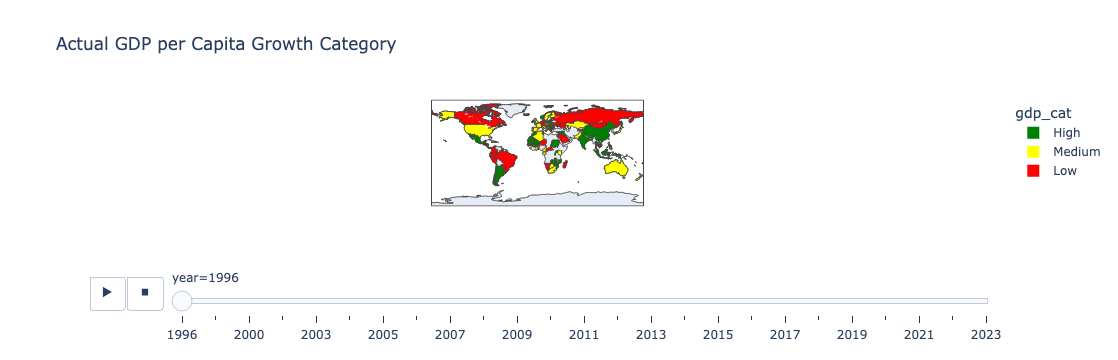

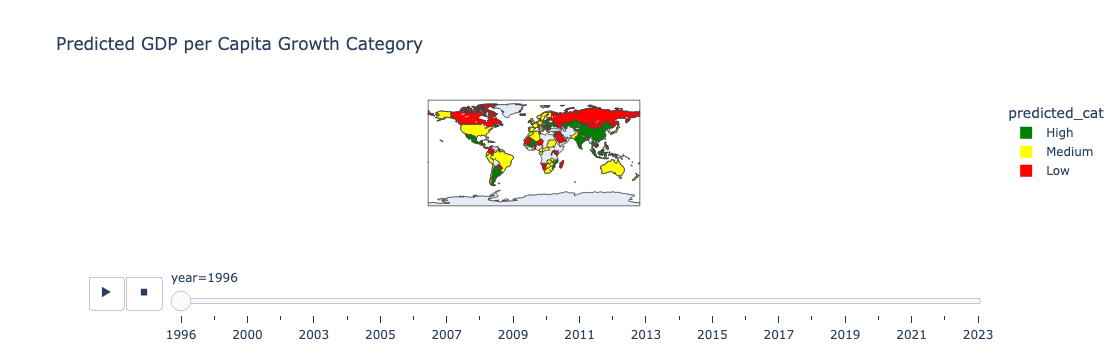

In [38]:
import plotly.express as px
model_df['gdp_cat'] = pd.qcut(model_df['gdp_pc_growth'], q=3, labels=['Low', 'Medium', 'High'])

# 3. Create predicted categories if you have numeric predictions
# Example: your RandomForest predictions mapped to 0,1,2
# If your predictions are in 'predicted_group':
model_df['predicted_cat'] = model_df['predicted_group'].map({0:'Low', 1:'Medium', 2:'High'})

color_map = {'Low':'red', 'Medium':'yellow', 'High':'green'}

# Animated choropleth for actual categories
fig_actual = px.choropleth(
    model_df,
    locations='country_std',
    color='gdp_cat',
    hover_name='country_std',
    animation_frame='year',
    color_discrete_map={'Low':'red','Medium':'yellow','High':'green'},
    locationmode='country names',   # this is key
    title='Actual GDP per Capita Growth Category'
)
fig_actual.show()

# Animated map for predicted
fig_pred = px.choropleth(
    model_df,
    locations='country_std',
    color='predicted_cat',
    hover_name='country_std',
    animation_frame='year',
    color_discrete_map=color_map,
    locationmode='country names',
    title='Predicted GDP per Capita Growth Category'
)
fig_pred.show()

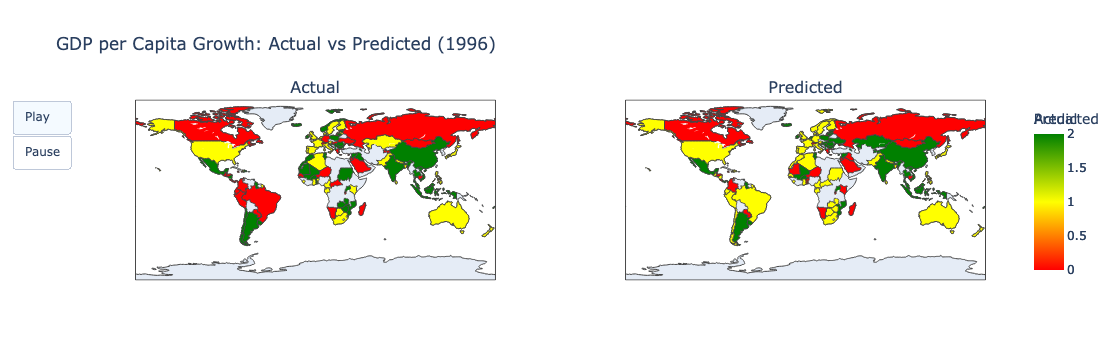

In [47]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Ensure numeric categories for coloring
model_df['gdp_cat_num'] = model_df['gdp_cat'].map({'Low': 0, 'Medium': 1, 'High': 2})
model_df['predicted_cat_num'] = model_df['predicted_cat'].map({'Low': 0, 'Medium': 1, 'High': 2})

years = sorted(model_df['year'].unique())

# Create subplots with 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]],
    subplot_titles=("Actual", "Predicted")
)

# Initial year data
year0 = years[0]
df0 = model_df[model_df['year'] == year0]

# Add initial traces
fig.add_trace(
    go.Choropleth(
        locations=df0['country_std'],
        z=df0['gdp_cat_num'],
        colorscale=['red', 'yellow', 'green'],
        zmin=0, zmax=2,
        showscale=True,locationmode='country names',
        colorbar=dict(title='Actual')
    ),
    row=1, col=1
)

fig.add_trace(
    go.Choropleth(
        locations=df0['country_std'],
        z=df0['predicted_cat_num'],
        colorscale=['red', 'yellow', 'green'],
        zmin=0, zmax=2,
        showscale=True,locationmode='country names',
        colorbar=dict(title='Predicted')
    ),
    row=1, col=2
)

# Create frames for each year
frames = []
for y in years:
    df_year = model_df[model_df['year'] == y]
    frames.append(go.Frame(
        data=[
            go.Choropleth(
                locations=df_year['country_std'],
                z=df_year['gdp_cat_num'],
                colorscale=['red', 'yellow', 'green'],
                zmin=0, zmax=2
            ),
            go.Choropleth(
                locations=df_year['country_std'],
                z=df_year['predicted_cat_num'],
                colorscale=['red', 'yellow', 'green'],
                zmin=0, zmax=2
            )
        ],
        name=str(y),
        layout=go.Layout(title_text=f"GDP per Capita Growth ({y})")
    ))

fig.frames = frames

# Add play/pause buttons
fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        buttons=[
            dict(label="Play", method="animate", args=[None, {"frame": {"duration": 1000, "redraw": True}, "fromcurrent": True}]),
            dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
        ]
    )],
    title_text=f"GDP per Capita Growth: Actual vs Predicted ({year0})"
)

fig.show()